In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
from torch import tensor
import random
import torch.nn as nn
import torch.autograd.functional as F
from manifold import Circle, Sphere, Manifold
from torch import einsum
import torch.autograd as autograd
from einops import rearrange, reduce, repeat
import torchsde
from torchsde import sdeint

In [2]:
eps = 1e-6

In [3]:
def strat_step(t, dt, y0, f_func, g_func, internal_clock, projection):
    t_new = t + dt 
    half_dt = 0.5 * dt
    t_prime = t + half_dt
    increment = torch.randn_like(y0) * dt ** 0.5

    f = f_func(y0, t) * internal_clock
    g = g_func(y0, t, increment) * internal_clock ** 0.5
    y_prime = y0 + half_dt * f + 0.5 * g
    f_prime = f_func(y_prime, t_prime) * internal_clock
    g_prod_prime = g_func(y_prime, t_prime, increment) * internal_clock ** 0.5

    y1 = y0 + dt * f_prime + g_prod_prime

    return projection(y1)

# Sphere
Let us work with the circle as a simple two dimensional manifold emboddied in the three dimensional xyz coordinates as the ambient space. 
We choose an arbitrary distribution $\mathbb{P}_{0}$ over the sphere(data distribution).

## data distribution over the sphere

In [4]:
twoPI =  2 * math.pi
PI = math.pi
def sample_from_P0_xtilde(n: int = 1):
    theta = (torch.rand(n) * 70 + 40)/(360) * twoPI
    phi = (torch.rand(n)* 110 + 50)/(360) * twoPI 
    return torch.stack([theta, phi], axis=1)

def sample_from_U_xtilde(n: int = 1):
    # see http://corysimon.github.io/articles/uniformdistn-on-sphere/ 
    # (Note theta and phi in this article is the exact opposite of what we are using here)
    phi = torch.rand(n) * twoPI - PI
    theta = torch.acos(1-2*torch.rand(n))
    return torch.stack([theta, phi], axis=1)

In [5]:
def sample_from_P0_xyz(n: int = 1):
    return Sphere.invphi(sample_from_P0_xtilde(n))

def sample_from_U_xyz(n: int = 1):
    return Sphere.invphi(sample_from_U_xtilde(n))

def sample_from_P1_xyz(n: int = 1):
    x = Sphere.invphi(sample_from_P0_xtilde(n))
    x = x + torch.randn_like(x)*0.1
    x = x/x.norm(dim=-1, keepdim=True)
    return x

In [6]:
x_tilde = sample_from_P0_xtilde(n = 2)
xyz = Sphere.invphi(x_tilde)
print(f'x_tilde: {x_tilde}')
print(f'xyz: {xyz}')
print(f'phi(xyz): {Sphere.phi(xyz)}')

x_tilde: tensor([[1.6693, 1.3097],
        [1.0897, 2.6318]])
xyz: tensor([[ 0.2569,  0.9614, -0.0984],
        [-0.7737,  0.4326,  0.4628]])
phi(xyz): tensor([[1.6693, 1.3097],
        [1.0897, 2.6318]])


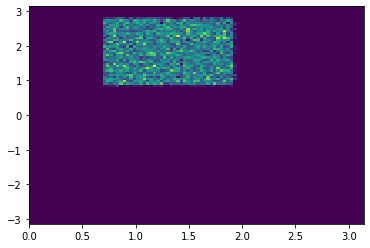

In [7]:
# plot on the two dimensional theta, phi axis
x_tilde = sample_from_P0_xtilde(n = 10000)
def plot_xtilde(x_tilde):
    x_tilde = x_tilde.detach()
    plt.hist2d(x=x_tilde[:, 0].numpy(), y=x_tilde[:, 1].numpy(), bins=100, range=((0, PI),(-PI, PI)))
    plt.show()
_ = plot_xtilde(x_tilde)

## estimate entropy of the UniformSlice

In [8]:
theta = 70/(360) * twoPI
phi = 110/(360) * twoPI 

In [9]:
x_tilde = sample_from_P0_xtilde(n = 10000)
x = Sphere.invphi(x_tilde)
A = 1/((theta*phi)*torch.sqrt(Sphere.g(x)))
torch.log(A).mean()

tensor(-0.7479)

In [10]:
x.shape

torch.Size([10000, 3])

In [11]:
A

tensor([0.4461, 0.4512, 0.5152,  ..., 0.4311, 0.4427, 0.5944])

In [12]:
x

tensor([[-0.5870,  0.7541, -0.2945],
        [ 0.2000,  0.9235, -0.3273],
        [ 0.5072,  0.6539,  0.5614],
        ...,
        [-0.3219,  0.9351,  0.1486],
        [-0.3079,  0.9126, -0.2690],
        [-0.4379,  0.5681,  0.6968]])

### plot

<Axes3DSubplot:>

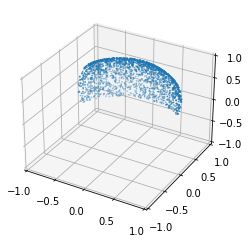

In [13]:
# plot on the three dimensional xyz
X = sample_from_P0_xyz(n=2000)
def plot_xyz(X):
    X = X.detach()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=0.5)
    ax.axes.set_xlim3d(left=-1., right=1) 
    ax.axes.set_ylim3d(bottom=-1, top=1) 
    ax.axes.set_zlim3d(bottom=-1, top=1)
    return ax

plot_xyz(X)

# Modeling the data: The Q

In [14]:
Xtilde = sample_from_P0_xtilde(n=100)
X = Sphere.invphi(Xtilde)

In [15]:
def projM(X):
    """
    X: the point on shpere in xyz coordinates
    return: projection matrix back to Sphere such that projM @ y is 
    in the tangent space of point X on the sphere while y itself may not be. 
    """
    XXT = torch.einsum('bi,bj->bij', (X, X))
    M = (torch.eye(3) - XXT)
    return M

projM(X).shape

torch.Size([100, 3, 3])

In [16]:
def dPhidX(X):
    """
    X: point on Sphere in xyz coordinates
    return: (d Sphere.phi) / (dX)
    refrence: https://discuss.pytorch.org/t/jacobian-functional-api-batch-respecting-jacobian/84571/6
    use martinsipka's answer for fast calculation in pytorch. PyTorch handles this awfully. Kudos to Jax!
    """
    phi = lambda x: torch.sum(Sphere.phi(x), axis=0)
    J = F.jacobian(phi, X, create_graph=True, strict=True).permute(1, 0, 2) # need to permute to have the right jacobian for batch, nasty :(
    return J

dPhidX(X).shape

torch.Size([100, 2, 3])

In [17]:
def dinvphi(y):
    invphi = lambda y: einsum('bd->d', Sphere.invphi(y))
    J = F.jacobian(invphi, y, create_graph=True, strict=True)
    J = rearrange(J, 'd b i -> b d i')
    return J

In [18]:
class SphericalBrownianMotion(torch.nn.Module):
    def __init__(self, T=1.0):
        super().__init__()
        self.T = T
        self.sde_type='ito'
        self.noise_type='general'

    def f(self, y, t):
        y = y.requires_grad_(True)
        sigma = self.g(y, t)
        patch_dim = 2
        bm_dim = 2
        gis = []
        for i in range(patch_dim):
            gjs = []
            for j in range(patch_dim):
                gks = []
                for k in range(bm_dim):
                    gk = autograd.grad(einsum('b->', sigma[:, i, k]),
                                       y,
                                       create_graph=True,
                                       retain_graph=True)[0][:, j]
                    gk = einsum('b,b->b',sigma[:,j,k], gk)
                    gks.append(gk)
                gks = rearrange(gks, 'k b -> b k')
                gj = einsum('bk->b', gks)
                gjs.append(gj)
            gjs = rearrange(gjs, 'j b -> b j')
            gi = einsum('bj->b', gjs)
            gis.append(gi)
        gis = rearrange(gis, 'i b -> b i')
        Mu = 0.5*gis
        return Mu

    def g(self, y, t):
        y3 = Sphere.invphi(y)
        return dPhidX(y3) @ projM(y3)
    
    def loop(self, y):
        theta = y[:, 0]
        y[:, 0] = torch.where(theta<0., -theta, theta)
        y[:, 0] = torch.where(theta>PI, twoPI-theta, theta)
        
        phi = y[:, 1]
        y[:, 1] = torch.where(phi>PI, phi-twoPI, phi)
        y[:, 1] = torch.where(phi<-PI, phi+twoPI, phi)
        
        return y
        
        

    def sample(self, y0, t, steps: int = 100):
        """
        y0: point on sphere in the patch [theta, phi]
        sample yt | y0
        """
        b = y0.shape[0] # batch_size
        dt = t/steps
        y = y0
        for step in range(steps):
            t = step*dt
            dW = torch.randn(b, 3) * dt ** 0.5 #shape: [batch, 3]
            noise = torch.einsum('bij,bj->bi', (self.g(y, t), dW)) # shape: [batch, 2] einsum is for matrix-vector multiplication withtout the unsqueeze, squeeze headaches!
            dy = self.f(y, t) * dt + noise
            y = self.loop(y + dy)
        return y  

In [19]:
sde = SphericalBrownianMotion()
x = sample_from_P0_xtilde(n=100).requires_grad_(True)
sde.f(Xtilde, 0.1).shape
sde.g(Xtilde, 0.1).shape

torch.Size([100, 2, 3])

In [20]:
Xtilde.shape

torch.Size([100, 2])

time is 0.001


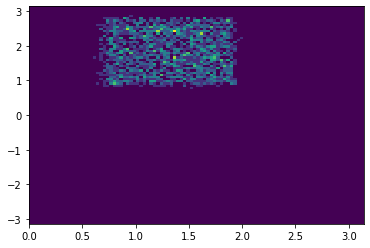

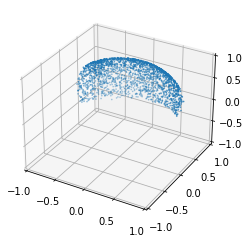

time is 0.1


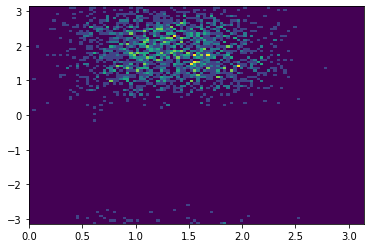

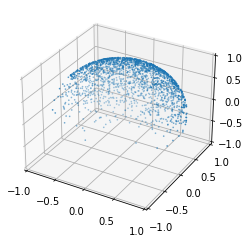

time is 1.0


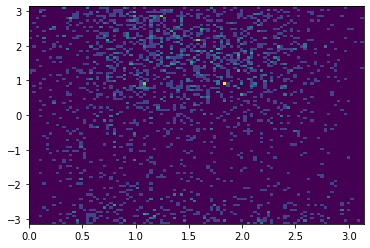

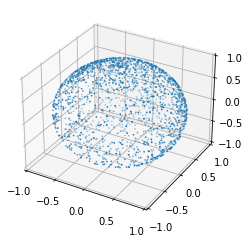

time is 2.0


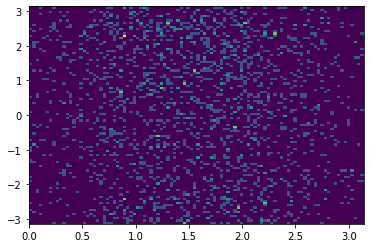

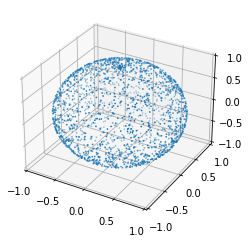

time is 3.0


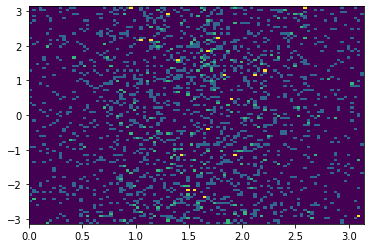

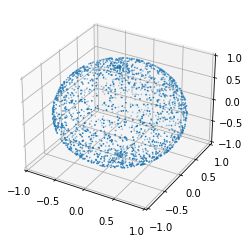

time is 10.0


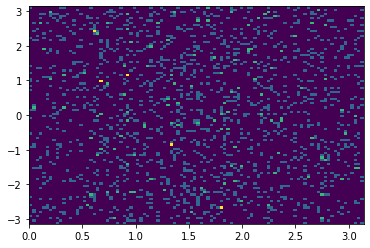

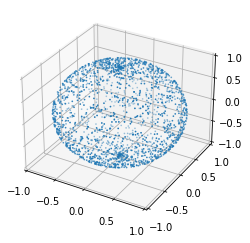

time is 20.0


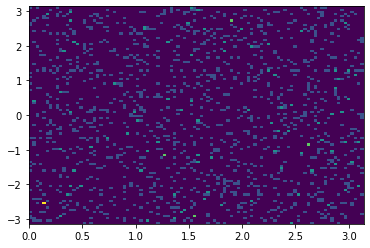

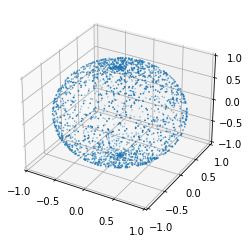

time is 100.0


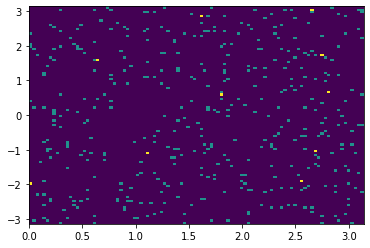

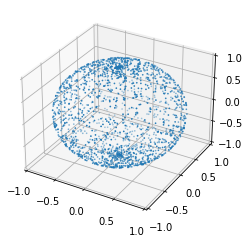

In [21]:
#plotting the diffusion process
x = sample_from_P0_xtilde(n = 2000)
sde = SphericalBrownianMotion()
for t in [0.001, 0.1, 1.0, 2.0, 3.0, 10.0, 20.0, 100.0]:
    print(f'time is {t}')
    y = sde.sample(x, t, steps=10)
    plot_xtilde(y)
    plot_xyz(Sphere.invphi(y))
    plt.show()

In [68]:
class AModule(nn.Module):
  def __init__(self, emb_size: int = 256):
    '''
    emb_size: a weak control over the embedding size for position and time embedding
    '''
    super(AModule, self).__init__()
    self.net = torch.nn.Sequential(
        nn.Linear(4, emb_size),
        nn.ELU(),
        nn.Linear(emb_size, emb_size),
        nn.ELU(),
        nn.Linear(emb_size, emb_size),
        nn.ELU(),
        nn.Linear(emb_size, 3)
    )
    
  def forward(self, x, t):
    print(type(Sphere.invphi(x)))
    print(type(t))
    return self.net(torch.cat([Sphere.invphi(x), t], 1))

AModule()(torch.rand(32, 3), torch.ones(32, 1)).shape

<class 'torch.Tensor'>
<class 'torch.Tensor'>


torch.Size([32, 3])

In [45]:
a = AModule()

In [46]:
# fbi
patch_dim = 2
bm_dim = 3
batch_size=32
y = sample_from_P0_xtilde(batch_size)
t = torch.ones(batch_size, 1)

def fbi(sde, y,t):
    y = y.requires_grad_(True)
    x = Sphere.invphi(y)
    detG = Sphere.g(x)
    gvol = (detG+eps) ** 0.5
    igvol = 1/(gvol+eps)

    sigma = sde.g(y, t)
    
    # A part of the fbi equation
    gis = []
    for i in range(patch_dim):
        gjs = []
        for j in range(patch_dim):
            gks = []
            for k in range(bm_dim):
                gk = autograd.grad(einsum('b,b->', gvol, sigma[:, j, k]), y, create_graph=True, retain_graph=True)[0] # shape:[batch, d(j)]
                gks.append(einsum('b,b->b', gk[:, j], sigma[:, i, k]))
            gks = rearrange(gks, 'k b -> b k')
            gj = einsum('bk->b', gks)
            gjs.append(gj)
        gjs = rearrange(gjs, 'j b -> b j')
        gi = einsum('bj->b', gjs)
        gis.append(gi)
    A = rearrange(gis, 'i b -> b i')
    

    # second part of the fbi equation
    h = einsum('bik,b,bjk->bij',(sigma, gvol, sigma))
    fbis = []
    for i in range(patch_dim):
        gs = []
        for j in range(patch_dim):
            g = autograd.grad(einsum('b->', h[:, i, j]), y, create_graph=True, retain_graph=True)[0] # shape:[batch, d(j)]
            gs.append(g[:, j])
        gs = rearrange(gs, 'j b -> b j')
        gi = einsum('bj->b', gs)
        fbis.append(gi)
    B = rearrange(fbis, 'i b -> b i')
    
    fb = einsum('bi,b->bi', A+B, 0.5*igvol)
    
    return fb


def VPhi0(sde, a, y, t):
    return fbi(sde, y, t) - sde.f(y, t) + einsum('bij, bj->bi', sde.g(y, t), a(y, t))


def FVSigma(sde, y, t):
    x = Sphere.invphi(y)
    detG = Sphere.g(x)
    gvol = detG ** 0.5
    
    # sum it all! do not forget the 0.5 at the beginning(TODO: make it quicker by being smart about i, j)
    res = []
    sigma = sde.g(y, t)
    for i in range(patch_dim):
        for j in range(patch_dim):
            for k in range(bm_dim):
                h = autograd.grad(einsum('b,b->', gvol, sigma[:, j,k]), y,
                                  create_graph=True, retain_graph=True)[0][:, j]
                h = einsum('b,b->b', sigma[:, i, k], h)
                h = autograd.grad(einsum('b->',h), y, 
                                  create_graph=True, retain_graph=True)[0]
                res.append(h[:, i])
    fvsigma = 0.5*sum(res)
    return fvsigma


def V(sde, a, y, t):
    y = y.requires_grad_(True)
    x = Sphere.invphi(y)
    
    detG = Sphere.g(x)
    gvol = detG ** 0.5
    igvol = 1/gvol
    
    vphi0 = VPhi0(sde, a, y, t)
    
    # First part
    g = autograd.grad(einsum('b->', gvol), y, create_graph=True, retain_graph=True)[0]
    A = einsum('bi,bi,b->b', g, vphi0, igvol)
    
    # Second part
    gs = []
    for i in range(patch_dim):
        g = autograd.grad(einsum('b->', vphi0[:, i]), y, create_graph=True, retain_graph=True)[0]
        gs.append(g[:, i])
    gs = rearrange(gs, 'i b -> b i')
    B = einsum('bi->b', gs)
    
    # Third part
    C = einsum('b,b->b', igvol, FVSigma(sde, y, t))
    V = A - B + C
    return V

VPhi0(sde, a, y, t).shape
V(sde, a, y, t).shape

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


torch.Size([32])

In [47]:
# this is a loss just for training, it is not ELBO (missing logp0) TODO: add the damn logp0 =)
def aloss(a, qsde, y, t):
    '''
    a: a used to reparametrize (it is aloss so we pass it first to the function :))
    qsde: the Q diffusion process
    sigma: note it is equivalent to g(X, t)
    y: samples of Xt under Q measure, i.e. samples from Q diffusion process
    t: times of the samples y
    '''

    # norm of a
    norm = (a(y, t)**2).sum(dim=-1)

    # V
    v = V(qsde, a, y, t)
    
    
    logpU = -torch.log(torch.tensor(4*math.pi))
    ll = (-0.5*norm + v)*qsde.T + logpU
    loss = -ll
    
    return loss

In [48]:
autograd.set_detect_anomaly(False)

In [49]:
a = AModule()
n_sample = 320
qsde = SphericalBrownianMotion()
opt = torch.optim.Adam(a.parameters(), lr=0.001)
T = 2.0

In [50]:
logpU = -torch.log(torch.tensor(4*math.pi))
logpU

tensor(-2.5310)

In [51]:
losses = []
for i in range(2):
    x = Sphere.phi(sample_from_P0_xyz(n = n_sample))
    t = repeat(torch.rand(n_sample), 'b -> b 1') * T
    y = qsde.sample(x, t)
#     y[:, 0] = y[:, 0]*0.95+0.025*PI
    y = y.requires_grad_(True)
    
    print(y.shape, t.shape)
    opt.zero_grad()
    loss = einsum('b->', aloss(a, qsde, y, t)) / n_sample
    
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    losses = losses[-1000:]
    if i%1 == 0:
        print(f'loss: {loss.item()}')

torch.Size([320, 2]) torch.Size([320, 1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
loss: 2.4910407066345215
torch.Size([320, 2]) torch.Size([320, 1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
loss: 1.8447659015655518


In [52]:
print(losses)
np.mean(losses)

[2.4910407066345215, 1.8447659015655518]


2.1679033041000366

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


19.75397

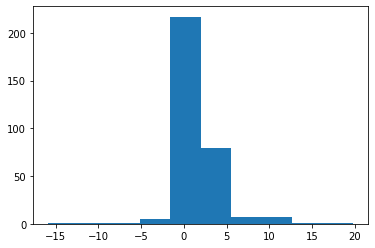

In [53]:
plt.hist(aloss(a, qsde, y, t).detach().numpy())
l = aloss(a, qsde, y, t).detach().numpy()
l[np.argmax(l)]


## sampling from the diffusion

In [54]:
class GenerativeStratanovichSDE(torch.nn.Module):
    def __init__(self, qsde, a, T=1.0):
        super().__init__()
        self.T = T
        self.qsde = qsde
        self.a = a

    
    def dinvphi(self, y):
        invphi = lambda y: einsum('bd->d', Sphere.invphi(y))
        J = F.jacobian(invphi, y, create_graph=True, strict=True)
        J = rearrange(J, 'd b i -> b d i')
        return J
        
    def V0(self, x, t):
        t = self.T - t # reverse time
        
        x = self.loop(x) # proj2manifold them back if out of manifold(stratanovich midpoints! ah!)
        y = Sphere.phi(x)
        vphi0 = VPhi0(self.qsde, self.a, y, t)
        J = self.dinvphi(y)
        v0 = einsum('bdi,bi->bd', J, vphi0)
        return v0

    def g(self, x, t):
        return projM(x)
    
    def loop(self, x):
        x = x/x.norm(dim=1).unsqueeze(-1)
        return x

gsde = GenerativeStratanovichSDE(qsde, a, T=T)

In [55]:
# just so torchsde accpets it
class TorchSDE(nn.Module):
    def __init__(self, gsde):
        super(TorchSDE, self).__init__()
        self.gsde = gsde
        self.sde_type='stratonovich'
        self.noise_type='general'
    
    def f(self, t, x):
        b = x.shape[0]
        t = torch.ones(b, 1)*t
        return self.gsde.V0(x, t)
    
    def g(self, t, x):
        b = x.shape[0]
        t = torch.ones(b, 1)*t
        return self.gsde.g(x, t)

In [56]:
tsde = TorchSDE(gsde)

In [57]:
autograd.set_detect_anomaly(False)

In [58]:
x0 = sample_from_U_xyz(n=4096)
steps = 2
xs = [x0]
ts = (torch.arange(1, steps)/steps)*T
for step in range(steps-2):
    if step%10 == 0:
        print(f'step {step} / 100')
    x = sdeint(tsde, xs[-1], ts[step:step+2]).detach()[1] # chooses the [xt, xt+1][1]
    x = tsde.gsde.loop(x)
    xs.append(x)

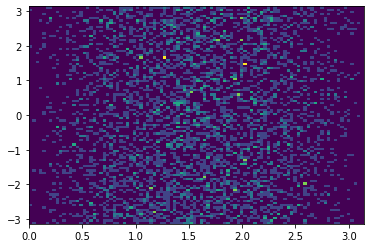

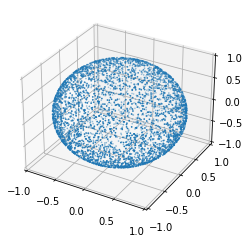

In [59]:
for i, t in enumerate(ts):
    if i % 20 == 0:
        x = xs[i]
        plot_xtilde(Sphere.phi(x))
        plot_xyz(x)
        plt.show()

In [60]:
x = torch.rand(32, 3)
x = x / x.norm(dim=1).unsqueeze(-1)
Sphere.invphi(Sphere.phi(x))

tensor([[3.8185e-01, 8.5795e-01, 3.4368e-01],
        [1.8275e-02, 6.7091e-01, 7.4131e-01],
        [2.1827e-01, 8.4154e-01, 4.9414e-01],
        [7.4758e-01, 1.8558e-01, 6.3772e-01],
        [4.8675e-01, 2.1665e-01, 8.4625e-01],
        [4.3317e-01, 9.0054e-01, 3.7386e-02],
        [5.7875e-01, 7.5319e-01, 3.1264e-01],
        [2.3208e-02, 7.4509e-01, 6.6656e-01],
        [6.4598e-01, 7.5851e-01, 8.5904e-02],
        [1.8418e-01, 6.9671e-01, 6.9330e-01],
        [3.3318e-01, 7.4216e-01, 5.8154e-01],
        [1.8109e-01, 2.9089e-01, 9.3946e-01],
        [4.2716e-01, 5.9957e-01, 6.7679e-01],
        [5.8453e-01, 6.1679e-01, 5.2716e-01],
        [4.0795e-01, 6.4616e-01, 6.4502e-01],
        [5.3918e-01, 3.8916e-01, 7.4688e-01],
        [3.6292e-01, 1.6259e-01, 9.1753e-01],
        [6.4311e-01, 7.4563e-01, 1.7449e-01],
        [4.7548e-01, 6.8447e-01, 5.5265e-01],
        [2.8125e-01, 7.1946e-01, 6.3504e-01],
        [6.0190e-01, 6.7452e-01, 4.2749e-01],
        [5.9885e-01, 6.3754e-01, 4

# Check FVSigma

In [61]:
n_sample=32
for i in range(2):
    x = Sphere.phi(sample_from_U_xyz(n = n_sample))
    t = repeat(torch.rand(n_sample), 'b -> b 1') * T
    y = qsde.sample(x, t)
    x = Sphere.invphi(y)
    detG = Sphere.g(x)
    gvol = detG ** 0.5
    igvol = 1/gvol
    r = einsum('b,b->b',igvol, FVSigma(sde, y, t))
    print(r.mean())

tensor(2.1968e-06, grad_fn=<MeanBackward0>)
tensor(-1.7941e-07, grad_fn=<MeanBackward0>)


# Train & Generate in Ambient Space

In [62]:
class AmbientSphericalBrownianMotion(torch.nn.Module):
    def __init__(self, T=1.0):
        super().__init__()
        self.T = T
        self.sde_type='stratonovich'
        self.noise_type='general'

    def f(self, x, t):
        """
        returns: drift for the spherical stratanovich brownian motion which is zero
        """
        return torch.zeros_like(x) #[batch_size, 3]

    def g_increment(self, x, t, increment):
        return einsum('bij, bj->bi', self.g(x, t), increment) #[batch_size, 3]
    
    def g(self, x, t):
        return projM(x)#[batch_size, 3, 3]
    
    def pi(self, x):
        """
        returns: projects back x to sphere
        """
        return x/x.norm(dim=-1, keepdim=True) #[batch_size, 3]
           

    def sample(self, x0, ts, steps: int = 100):
        x = x0
        t = 0
        dt = 1/steps
        while t<1:
            t += dt
            x = strat_step(t, dt, x, self.f, self.g_increment, ts, self.pi)
        return x

time is 0.001


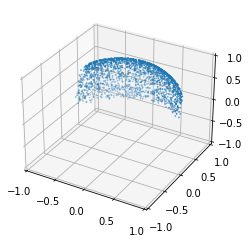

time is 0.1


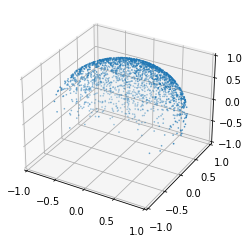

time is 1.0


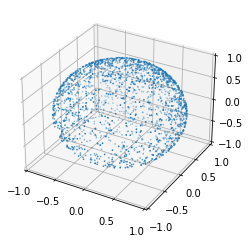

time is 2.0


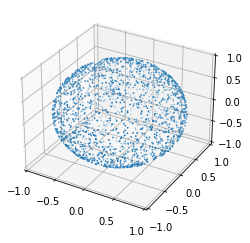

time is 3.0


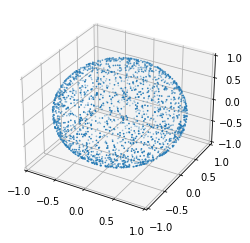

time is 10.0


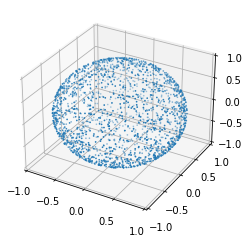

time is 20.0


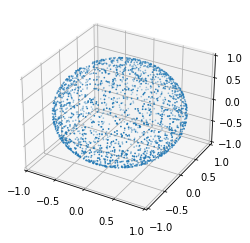

time is 100.0


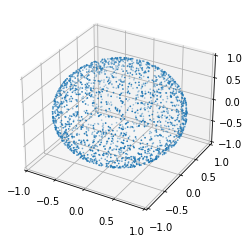

In [63]:
#plotting the diffusion process
x = sample_from_P0_xyz(n = 2000)
sde = AmbientSphericalBrownianMotion(T=1.0)
for t in [0.001, 0.1, 1.0, 2.0, 3.0, 10.0, 20.0, 100.0]:
    print(f'time is {t}')
    x = sde.sample(x, t, steps=100)
    plot_xyz(x)
    plt.show()

In [64]:
class AmbientAModule(nn.Module):
    def __init__(self, emb_size: int = 256):
        '''
        emb_size: a weak control over the embedding size for position and time embedding
        '''
        super(AmbientAModule, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(4, emb_size),
            nn.ELU(),
            nn.Linear(emb_size, emb_size),
            nn.ELU(),
            nn.Linear(emb_size, emb_size),
            nn.ELU(),
            nn.Linear(emb_size, 3)
    )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], 1))

AmbientAModule()(torch.rand(32, 3), torch.ones(32, 1)).shape

torch.Size([32, 3])

In [65]:
def divergence(v, x):
    '''
    returns: divergence of v(x) w.r.t x [batch_size]
    '''
    J = F.jacobian(lambda x: einsum('bd->d', v(x)), x, create_graph=True, strict=True)
    J = rearrange(J, 'o b i -> b o i')
    div = einsum('bij->b', J * torch.eye(3))
    return div

def VAlphaterm(sde, x, t, manifold: str = None):
    if manifold == "Sphere":
        return torch.zeros(x.shape[0], 3)
    hs = []
    for k in range(bm_dim):
        v = lambda x: sde.g(x, t)[:,:,k] 
        div = divergence(v, x)
        hs.append(repeat(div, 'b -> b 1') * v(x))
    return sum(hs) # [batch_size, bm_dim]

def AmbientFVSigma(sde, x, t, manifold: str = None):
    if manifold == "sphere": # to make manifold-specific heuristics
        return torch.zeros(x.shape[0])
    return 0.5*divergence(lambda x: VAlphaterm(sde, sde.pi(x), t), x)

In [71]:
def V0(sde, a, x, t):
    vterm = VAlphaterm(sde, x, t, manifold='sphere')
    return vterm + einsum('bij,bj->bi', sde.g(x, t), a(x, t))
# V0(sde, a, x, t).shape

In [73]:
def V(sde, a, x, t):
    A = -divergence(lambda x: V0(sde, a, sde.pi(x), t), x) #TODO is sde.pi needed?
    B = AmbientFVSigma(sde, x, t, manifold='sphere')
    return A+B
# V(sde, a, x, t).shape

In [75]:
# this is a loss just for training, it is not ELBO (missing logp0) TODO: add the damn logp0 =)
def aloss(qsde, a, y, t):
    '''
    a: a used to reparametrize (it is aloss so we pass it first to the function :))
    qsde: the Q diffusion process
    sigma: note it is equivalent to g(X, t)
    y: samples of Xt under Q measure, i.e. samples from Q diffusion process
    t: times of the samples y
    '''

    # norm of a
    norm = (a(y, t)**2).sum(dim=-1)

    # V
    v = V(qsde, a, y, t)
    
    
    logpU = -torch.log(torch.tensor(4*math.pi))
    ll = (-0.5*norm + v)*qsde.T + logpU
    loss = -ll
    
    return loss
# aloss(sde, a, x, t)

In [76]:
a = AmbientAModule()
n_sample = 32
qsde = AmbientSphericalBrownianMotion()
opt = torch.optim.Adam(a.parameters(), lr=0.0003)
T = 2.0

In [77]:
losses = []
for i in range(10000):
    x = sample_from_P0_xyz(n = n_sample)
    t = repeat(torch.rand(n_sample), 'b -> b 1') * T
    y = qsde.sample(x, t)
    y = y.requires_grad_(True)
    
    opt.zero_grad()
    loss = einsum('b->', aloss(qsde, a, y, t)) / n_sample
    
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    losses = losses[-1000:]
    if i%100 == 0:
        print(f'iter: {i} loss: {loss.item()} last1000mu:{sum(losses)/len(losses)}')

iter: 0 loss: 2.5381176471710205 last1000mu:2.5381176471710205
iter: 100 loss: 2.347266912460327 last1000mu:2.1531317293053807
iter: 200 loss: 2.268496513366699 last1000mu:2.14207759010258
iter: 300 loss: 2.5258519649505615 last1000mu:2.1346548205594287
iter: 400 loss: 2.1374168395996094 last1000mu:2.1001680485922796
iter: 500 loss: 1.8740406036376953 last1000mu:2.07295835375072
iter: 600 loss: 2.1132867336273193 last1000mu:2.0639296918859498
iter: 700 loss: 2.241041898727417 last1000mu:2.0495096763088427
iter: 800 loss: 1.6301928758621216 last1000mu:2.0309127846014188
iter: 900 loss: 1.8480530977249146 last1000mu:2.026236373364727
iter: 1000 loss: 2.4059267044067383 last1000mu:2.0139683138132094
iter: 1100 loss: 2.143160581588745 last1000mu:1.9875910255908966
iter: 1200 loss: 2.325227975845337 last1000mu:1.9664290484786033
iter: 1300 loss: 2.041182041168213 last1000mu:1.945563669860363
iter: 1400 loss: 1.7236617803573608 last1000mu:1.9355282890200616
iter: 1500 loss: 1.198281288146972

## generating from the diffusion process

In [78]:
class GenerativeStratanovichSDE(torch.nn.Module):
    def __init__(self, qsde, a):
        super().__init__()
        self.T = qsde.T
        self.qsde = qsde
        self.a = a
        self.sde_type='stratonovich'
        self.noise_type='general'
        
    def V0(self, x, t):
        x = self.qsde.pi(x) # proj2manifold back to manifold because of stratanovich mid-points
        t = self.T - t # reverse time
        return V0(self.qsde, self.a, x, t)
        return v0

    def g(self, x, t):
        return projM(x)
    
    def g_increment(self, x, t, increment):
        return einsum('bij, bj->bi', self.g(x, t), increment)
    
    def sample(self, x0, ts, steps: int = 100):
        x = x0
        t = 0
        dt = 1/steps
        while t<1:
            t += dt
            x = strat_step(torch.ones_like(ts)*t, dt, x, self.V0, self.g_increment, ts, self.qsde.pi)
        return x

In [82]:
gsde = GenerativeStratanovichSDE(qsde, a)
tsde = TorchSDE(gsde)
x0 = sample_from_U_xyz(n=2000)
print(x0)
steps = 100
ts = torch.ones(x0.shape[0], 1)*gsde.T
x = gsde.sample(x0, ts, steps=steps)

tensor([[-0.4993,  0.5527, -0.6672],
        [ 0.6659, -0.0015, -0.7461],
        [-0.7556, -0.4511, -0.4750],
        ...,
        [ 0.6872, -0.4547,  0.5666],
        [ 0.3582,  0.6977,  0.6204],
        [-0.5613, -0.2046,  0.8019]])


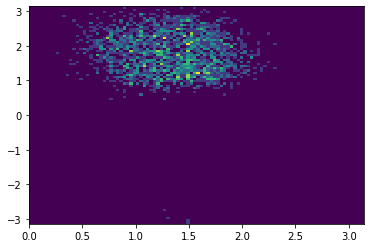

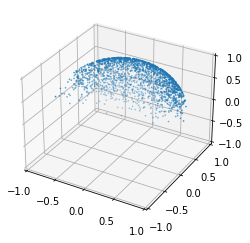

In [80]:
plot_xtilde(Sphere.phi(x))
plot_xyz(x)
plt.show()